<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/sklearn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 6)사이킷런으로 수행하는 타이타닉 생손자 예측


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
titanic_df = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')
titanic_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
print('\n ###학습 데이터 정보 ###\n')

#로딩된 데이터 칼럼 타입을 확인하자.
print(titanic_df.info())


 ###학습 데이터 정보 ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


* RangeIndex는 DataFrame인덱스의 범위를 나타내므로 전체 로우 수를 알 수 있다.
* 판다스의 object 타입은 string타입으로 봐도 무방하다.
* 사이킷런 머신러닝 알고리즘은 null갑승ㄹ 허용하지 않으므로 이를 처리해야한다. 

In [10]:
#fillna를 이용하여 평균 또는 고정값으로 변경한다.
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 널값 개수', 'N', titanic_df.isnull().sum().sum())

데이터 세트 널값 개수 N 0


In [11]:
#남아있는 문자열 피처는 sex, cabin, embarked이다. 이 값 분류를 살펴보자
print('Sex값 분포:\n', titanic_df['Sex'].value_counts())
print('\n Cabin값 분포:\n', titanic_df['Cabin'].value_counts())
print('\n Embarked값 분포:\n', titanic_df['Embarked'].value_counts())

Sex값 분포:
 male      577
female    314
Name: Sex, dtype: int64

 Cabin값 분포:
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked값 분포:
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


sex, embarked값은 별 문제가 없지만 cabin의 경우 N이 가장 많은 것도 특이하고 속성값이 제대로 정리가 되지 않은 것 같다.

In [12]:
titanic_df['Cabin']=titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


머신러닝 알고리즘을 적용해 예측을 수행하기 전에 데이터 탐색하자.

1. 어떤 유형의 승객이 생존 확률이 높았는지 확인하자.

In [13]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()
#0은 사망, 1은 생존

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

#### **그래프로 확인하기**
시각화는 시본 패키지를 이용한다. (Seaborn)


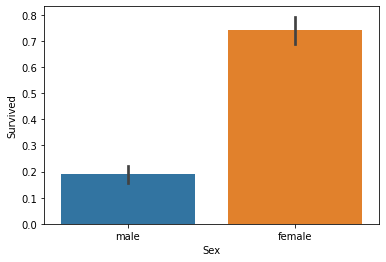

In [14]:
sns.barplot(x='Sex',y='Survived', data=titanic_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


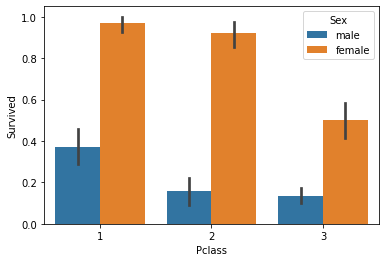

In [15]:
#부자와 가난한 사람들 조사
sns.barplot('Pclass','Survived',hue='Sex', data=titanic_df)

여성의 경우 일,이등실에 따른 생존 확률의 차이는 크지 않으나 삼등실일 경우 상대적으로 떨어짐을 알 수 있다. 
이번에는 age에 따른 생존 확률을 알아보자. 
범위별로 분류해 카테고리 값을 할당한다.

In [18]:
#입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용
def get_category(age):
  cat=''
  if age<= -1: cat='Unknown'
  elif age<=5: cat='Baby'
  elif age<=12: cat='Child'
  elif age<=18: cat='Teenager'
  elif age<=25: cat='Student'
  elif age<=35: cat='Young Adult'
  elif age<=60: cat='Adult'
  else: cat='Elderly'

  return cat

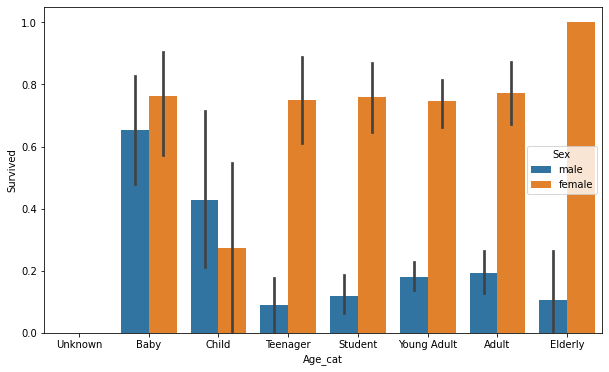

In [19]:
#막대그래프 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

#x축 값을 순차적ㅇ로 표시하기 위한 설정
group_names=['Unknown','Baby','Child','Teenager','Student','Young Adult','Adult','Elderly']

#lambda 식에 위에서 생성한 get_category()함수를 반환값으로 지정.
#get_category(X)는 입력값으로 'Age'칼럼 값을 받아서 해당하는 cat반환
titanic_df['Age_cat']=titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat',axis=1, inplace=True)

이제 남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환하겠다. 


인코딩은 사이킷런의 LabeEencoder클래스를 이용해 레이블 인코딩을 적용한다.

In [39]:
from sklearn import preprocessing

def encode_features(dataDF):
  features=['Cabin','Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le=le.fit(dataDF[feature])
    dataDF[feature]=le.transform(dataDF[feature])

  return dataDF

titanic_df=encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2


-> sex, cabin, embarked 속성이 숫자형으로 바뀐 것을 알 수 있다.


지금까지 피처를 가공한 내역을 정리하고 이를 함수로 만들어 재사용할 수 있도록 만들겠다. 

데이터의 전처리를 전체적으로 호출하는 함수는** transform_features()이며 Null처리, 포매팅, 인코딩을 수행하는 내부함수**로 구성했다.

In [40]:
#Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

#레이블 인코딩 수행.
def format_features(df):
  df['Cabin']=df['Cabin'].str[:1]
  features=['Cabin','Sex','Embarked']
  for feature in features:
    le=LabelEncoder()
    le=le.fit(df[feature])
    df[feature]=le.transform(df[feature])
  return df

#앞에서 설정한 전처리 함수 호출
def transform_features(df):
  df=fillna(df)
  df=drop_features(df)
  df=format_features(df)
  return df


이제 다시 원본 데이터를 가공해보자.

In [46]:
from google.colab import drive
drive.mount('/content/drive')
titanic_df = pd.read_csv('/content/drive/MyDrive/titanic_train.csv')

titanic_df

y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)

X_titanic_df=transform_features(X_titanic_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored

In [34]:
#별도의 테스트 데이터 세트를 추출합니다. 크기는 전체의 0.2로
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

ML알고리즘인 결정트리, 랜덤 포레스트, 로지스틱 회귀를 이용해 타이타닉 생손자를 예측해보자.

* DecisionTreeClassifier : 결정트리
* RandomForestClassifier : 랜덤 포레스트
* LogisticRegression : 로지스틱 회귀
를 위해 이 클래스를 제공한다.

이들 클래스를 이용해 train_test_split()으로 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습하고 예측할 것이다. 
예측 성능 평가는 정확도로 할 것이고 이를 위해 accuracy_score() API를 사용한다.



In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier클래스 생성
dt_clf=DecisionTreeClassifier(random_state=11)
rt_clf=RandomForestClassifier(random_state=11)
lr_clf=LogisticRegression

#DecisionTreeClassifier학습/예측 /평가
dt_clf.fit(X_train, y_train)
dt_pred=dt_clf.predict(X_test)
print('DecisionTreeClassifier정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))

#RandomForestClassifier 학습/예측 /평가
rt_clf.fit(X_train, y_train)
rt_pred=dt_clf.predict(X_test)
print('RandomForestClassifier정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))


#LogisticRegression 학습/예측 /평가
lr_clf.fit(X_train, y_train)
lr_pred=dt_clf.predict(X_test)
print('LogisticRegression정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))


ValueError: ignored

->

다음으로 교차 검증으로 결정 트리 모델을 평가해보자
* model_selection 패키지의 KFold클래스, cross_val_score(), GridSearchCV 클래스를 모두 이용


In [37]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
  #폴드 세트를 5개인 kfold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
  kfold=KFold(n_splits=folds)
  scores=[]

  #KFold 교차 검증 수행
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    #X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test= X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test= y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    #Classifier 학습, 예측 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy=accuracy_score(y_test, predictions)
    scores.append(Accuracy)
    print('교차 검증 {0} 정확도:{1:.4f}'.format(iter_count, accuracy))

  #5개 fold에서의 평균 정확도 계산
  mean_score = np.mean(scores)
  print("평균 정확도: {0:.4f}".format(mean_score))
#exec_kfold호출
exec_kfold(dt_clf, folds=5)


ValueError: ignored

In [42]:
#cross_val_score() 을 이용해 수행해보자.
from sklearn.model_selection import cross_val_score

scores=cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
  print('교차 검증 {0} 정확도:{1:.4f}'.format(iter_count, accuracy))

print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도:nan
교차 검증 1 정확도:nan
교차 검증 2 정확도:nan
교차 검증 3 정확도:nan
교차 검증 4 정확도:nan
평균 정확도:nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 166, in fit
    X, y, validate_separately=(check_X_params, check_y_params)
  File "/usr/local/lib/python3.7/dist-package

두개가 평균 정확도가 약간 다른데 이는 cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할하기 때문이다.

마지막으로 GridSearchCV를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능을 측정해보자.

CV는 5개의 폴드 세트를 지정하고 하이퍼 파라미터는 max_depth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정한다.

최적 하이퍼 파라미터와 그때의 예측을 출력하고, 최적 하이퍼 파라미터로 학습된 estimator을 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행해 얘측 정확도를 출력하겠다.

In [45]:
from sklearn.model_selection import GridSearchCV

parameters={'max_depth':[2,3,5,10], ' min_samples_split':[2,3,5],'min_samples_leaf':[1,5,8] }

grid_dclf=GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_dclf.best_score_))
best_dclf=grid_dclf.best_estimator_

#GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가수행
dpredictions = best_dclf.predict(X_test)
accuracy=accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 :{0:.4f}'.format(accuracy))

ValueError: ignored

최적화된 하이퍼 파라미터로 학습시킨 뒤 예측 정확도가 향상됐다. 일반적으로 하이퍼 파라미터를 튜닝하더라도 이정도 수준으로 증가하기는 매우 어렵다. 테스트용 데이터 세트가 작기 때문에 예측 성능이 많이 증가한 것처럼 보인다!